\newpage

# A Deep (Sea) Dive into Crown-of-Thorns Starfish Underwater Image Data{-}


# Introduction

This report presents findings from the exploratory data analysis (EDA) conducted on underwater image data for Crown-of-Thorns Starfish (COTS) detection. The guiding objective for this project is to develop an algorithm to detect COTS in underwater image data. Subequently, the goal of this analysis is to better under the data structure and the characteristics of the underwater image data (e.g., patterns in scale and location of COTS) that can influence model design decisions to improve starfish detection.

The dataset is composed of `jpg` images and a `csv` file that details the video, sequence and bounding box dimensions per image. All images have width 1280 pixels and height 720 pixels.

In [504]:
import warnings
warnings.filterwarnings('ignore')

# Main PySpark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F, types as T

spark = SparkSession.builder.appName('MySparkSession').getOrCreate()

# General Imports
import logging
from itertools import cycle
from tqdm import tqdm
import os
import random

# All Other Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px
import cv2

from IPython.display import HTML, display

25/03/08 18:41:16 WARN Utils: Your hostname, Bushras-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.88.111.15 instead (on interface en0)
25/03/08 18:41:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/08 18:41:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [505]:
# Aesthetics

plotly_default = px.colors.qualitative.Plotly
snspal = sns.color_palette('mako_r')
snspal = plotly_default

%matplotlib inline

In [506]:
# Define Schemas
bbox_schema = T.ArrayType(
    T.StructType([
        T.StructField('x', T.IntegerType(), True),
        T.StructField('y', T.IntegerType(), True),
        T.StructField('width', T.IntegerType(), True),
        T.StructField('height', T.IntegerType(), True)
    ])
)

In [507]:
labels = spark.read.csv('/Users/bushra/Documents/STA2453/tensorflow-great-barrier-reef/train.csv', header=True)\
    .select(
        F.col('video_id').cast(T.StringType()),
        F.col('sequence').cast(T.StringType()),
        F.col('video_frame').cast(T.IntegerType()),
        F.col('sequence_frame').cast(T.IntegerType()),
        F.col('image_id').cast(T.StringType()),
        F.col('annotations').cast(T.StringType())
    )

bboxs = labels\
    .withColumn('annotations_formatted', F.from_json(F.col('annotations'), bbox_schema))\
    .select('video_id', 'sequence', 'image_id', 'video_frame', F.posexplode(F.col('annotations_formatted')).alias('bbox_id', 'bbox'))\
    .withColumns({
        'x': F.col('bbox.x'),
        'y': F.col('bbox.y'),
        'width': F.col('bbox.width'),
        'height': F.col('bbox.height')
    })\
    .withColumn('size', F.col('width') * F.col('height'))\
    .withColumn('x_center', F.col('x') + (F.col('width') / F.lit(2)))\
    .withColumn('y_center', F.col('y') + (F.col('height') / F.lit(2)))

labels = labels\
    .join(
        bboxs\
            .groupBy('image_id')\
            .agg(F.countDistinct('bbox_id').alias('n_cots')),
        on='image_id',
        how='left'
    )\
    .fillna(0, subset=['n_cots'])\
    .withColumn('has_cots', F.when(F.col('n_cots') >= 1, 1).otherwise(0))\
    .withColumn('n_cots_bucket',
                F.when(F.col('n_cots')==0, '0')\
                 .when(F.col('n_cots').between(1,5), '1-5')\
                 .when(F.col('n_cots').between(6,10), '6-10')\
                 .when(F.col('n_cots').between(11,15), '11-15')\
                 .otherwise('15+'))

# labels.show(5)
# bboxs.show(5)

# Overview of Image Data
This section examines the distribution of images across videos and sequences at a high-level. 

## How have the original videos been decomposed into images?
There are 3 underwater videos divided into 8 sequences (4 for video 2), with unknown ordering, so it is unclear if all videos and sequences represent the same reef. The filming details (time, season, region) are also unknown. From Table 1, note that Video 0, with 8 sequences, contributes the least number of images, possibly due to filming smaller, more distant areas, resulting in more breaks and sequences. On the other hand, Video 0 contributes the most number of images with only 4 sequences of videos, possible due to filming larger areas at a time.

<div style="text-align: center;"><strong>Table 1: Count of Sequences and Images per Video</strong></div>

| Video ID | No. Sequences | No. Images |
|----------|--------------|------------|
| 0        | 8            | 6708       |
| 1        | 8            | 8232       |
| 2        | 4            | 8561       |

In [ ]:
labels1 = labels\
    .groupBy('video_id')\
    .agg(
        F.count('*').alias('n_images'),
        F.countDistinct('sequence').alias('n_sequences'),
        F.countDistinct('video_frame').alias('n_frames'),
        F.sum(F.when(F.col('annotations')=='[]',0).otherwise(1)).alias('n_images_cots')
    )\
    .withColumn('pct_images_cots', F.round(F.col('n_images_cots') / F.col('n_images'), 3))\
    .withColumn('n_images_no_cots', F.col('n_images') - F.col('n_images_cots'))\
    .withColumn('pct_images_no_cots', F.round(F.col('n_images_no_cots') / F.col('n_images'), 3))

# labels1.show()

+--------+--------+-----------+--------+-------------+---------------+----------------+------------------+
|video_id|n_images|n_sequences|n_frames|n_images_cots|pct_images_cots|n_images_no_cots|pct_images_no_cots|
+--------+--------+-----------+--------+-------------+---------------+----------------+------------------+
|       0|    6708|          8|    6708|         2143|          0.319|            4565|             0.681|
|       1|    8232|          8|    8232|         2099|          0.255|            6133|             0.745|
|       2|    8561|          4|    8561|          677|          0.079|            7884|             0.921|
+--------+--------+-----------+--------+-------------+---------------+----------------+------------------+



In [509]:
labels2 = labels\
    .groupBy('video_id', 'sequence')\
    .agg(
        F.count('*').alias('n_images'),
        F.countDistinct('video_frame').alias('n_frames'),
        F.countDistinct('sequence_frame').alias('n_seq_frames'),
        F.sum(F.when(F.col('annotations')=='[]',0).otherwise(1)).alias('n_images_cots')
    )\
    .withColumn('pct_images_cots', F.round(F.col('n_images_cots') / F.col('n_images'), 3))\
    .withColumn('n_images_no_cots', F.col('n_images') - F.col('n_images_cots'))\
    .withColumn('pct_images_no_cots', F.round(F.col('n_images_no_cots') / F.col('n_images'), 3))\
    .orderBy('video_id', 'n_images')

# labels2.show(5)

In [510]:
sequence_start_end = labels\
    .groupBy('video_id', 'sequence')\
    .agg(
        F.countDistinct('video_frame').alias('n_images'),
        F.min(F.col('video_frame')).alias('min_frame_id'),
        F.max(F.col('video_frame')).alias('max_frame_id')
    )\
    .orderBy('video_id', 'min_frame_id')

# sequence_start_end.show()

Figure 1 illustrates the distribution of sequences across videos. Continuing from above, Video 1 has 8 sequences although more than half contain very few images, and with only two sequences contributing nearly 3000 images each. In contrast, Video 2 has only 4 sequences, but each contributes a substantial number of images, with at least 1,500 per sequence. Note the sequence labels are arbitrary so they have been excluded.

\newpage

<div style="text-align: center;"><strong>Figure 1: Images per Sequence in each Video</strong></div>

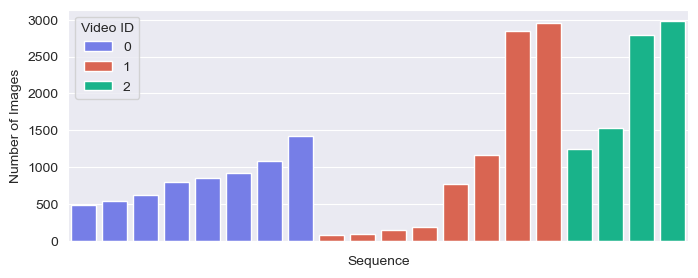

In [511]:
df_labels2 = labels2.toPandas()\
    .rename(columns={'video_id': 'Video ID',
                     'sequence': 'Sequence',
                     'n_images': 'Number of Images'})

sns.set_style('darkgrid')
plt.figure(figsize=(8,3))
g = sns.barplot(data=df_labels2, x='Sequence', y='Number of Images', hue='Video ID', palette=snspal)
g.set(xticklabels=[])
g.legend(title='Video ID')
plt.show()

## How are COTS distributed across videos and sequences?
Figure 2 shows that Video 0 has the highest proportion of COTS occurrences, with 31.9% of its 6,708 images containing COTS. In contrast, Video 2 has a larger dataset of 8,561 images but a significantly lower COTS presence at only 7.9%. This suggests that the videos may have surveyed different areas or at different times with varying COTS densities. When training the model, it may be beneficial to use weighted algorithms to give more emphasis to Video 0.

<div style="text-align: center;"><strong>Figure 2: Images with and without COTS</strong></div>

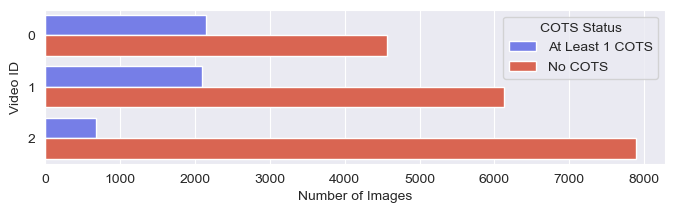

In [512]:
df_labels1 = labels1.toPandas()\
    .melt(id_vars=['video_id'],
          value_vars=['n_images_cots', 'n_images_no_cots'], 
          var_name='COTS Status', 
          value_name='Number of Images')\
    .rename(columns={'video_id': 'Video ID'})\
    .replace(to_replace={'n_images_cots': 'At Least 1 COTS', 
                         'n_images_no_cots': 'No COTS'})


sns.set_style('darkgrid')
plt.figure(figsize=(8, 2))
sns.barplot(data=df_labels1, y='Video ID', x='Number of Images', hue='COTS Status', palette=snspal)
plt.legend(title='COTS Status')
plt.show()

Figure 3 orders images by their frame index, with gaps indicating breaks between sequences. Video 0 shows almost no COTS across all images, and those that do contain COTS have fewer than five each. Similarly, Video 1 has very few COTS overall, but when present, they often appear in high numbers (>10), which could help the model learn to detect clusters rather than individual COTS. Video 2 also has minimal COTS presence, except for what appears to be the third sequence, where a significant number of images contain more than 15 COTS, suggesting another example of high clustering of COTS.

\newpage

<div style="text-align: center;"><strong>Figure 3: Number of COTS in each Image per Video</strong></div>

<Figure size 400x300 with 0 Axes>

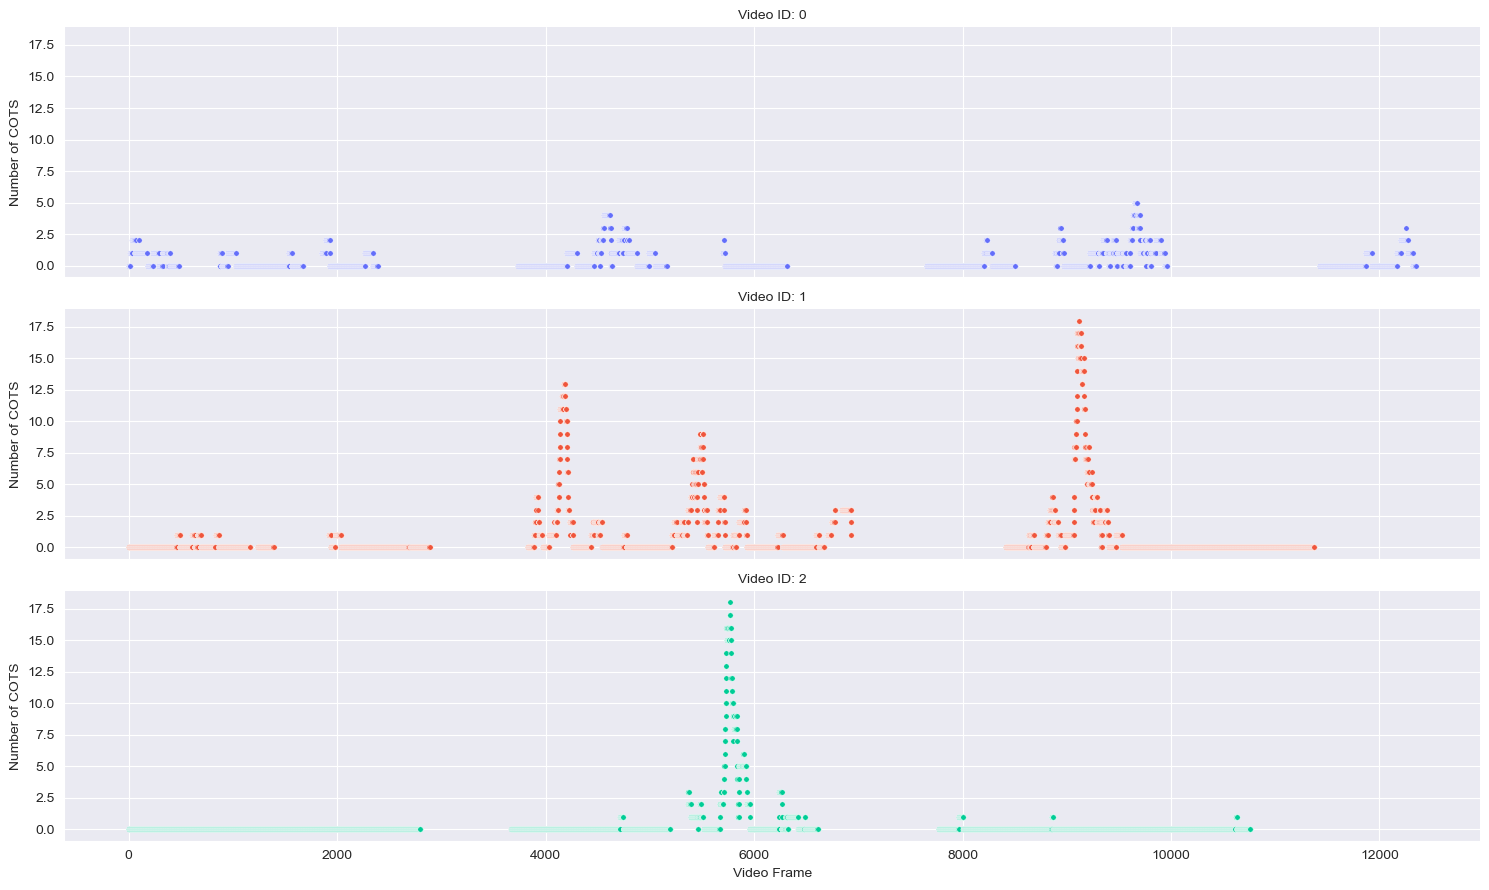

In [513]:
df_labels = labels.toPandas()\
    .rename(columns={'video_frame': 'Video Frame',
             'n_cots': 'Number of COTS',
             'video_id': 'Video ID'})

sns.set_style('darkgrid')
plt.figure(figsize=(4, 3))
g = sns.FacetGrid(df_labels, 
                  row='Video ID', sharex=True, hue='Video ID', palette=snspal, aspect=5)
g.map_dataframe(sns.scatterplot, x='Video Frame', y='Number of COTS', s=15)
g.set_titles(row_template='Video ID: {row_name}')
plt.show()

# Examining Annotations & Distribution of COTS
This sections takes a closer look into bounding boxes and their distributions. Since bounding boxes are used to label COTS, they are geometrically correlated to the scale and location of the starfish and can be used to get a general idea of how the starfish present in the images.

## How large are bounding boxes?
Figure 4 shows plots with outliers (bounding boxes > 10,000 pixels) excluded. In Video 0, bounding boxes typically average around 1,500 pixels, but there are more images with larger sizes compared to the other two videos. In Videos 1 and 2, bounding boxes generally range from the high 1,000s to 2,500 pixels, with very few exceeding 7,000 pixels. This aligns with the previous idea that Video 0 might represent more distinct areas and thus more variety in the sizes of the COTS captured.

\newpage

<div style="text-align: center;"><strong>Figure 4: Distribution of Bounding Box Sizes</strong></div>

<Figure size 2000x500 with 0 Axes>

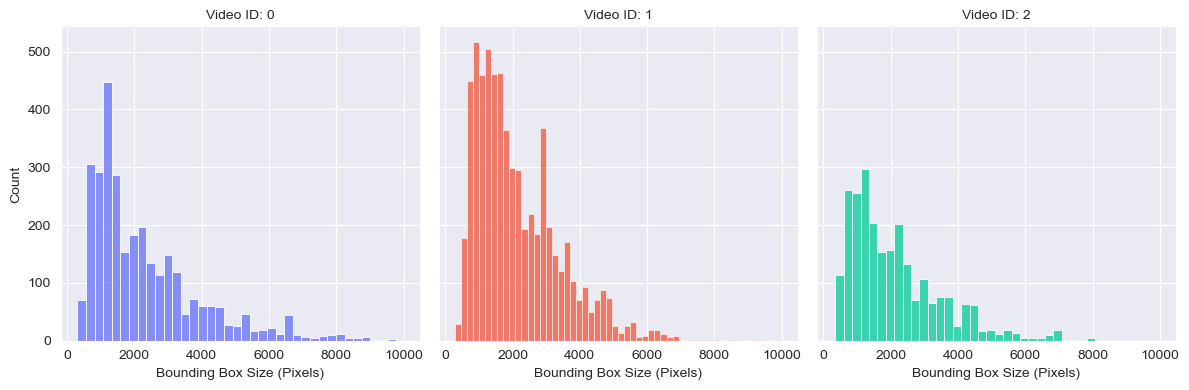

In [514]:
df_bboxs = bboxs.toPandas()\
    .rename(columns={'video_id': 'Video ID',
                     'image_id': 'BBox ID',
                     'video_frame': 'Video Frame',
                     'sequence': 'Sequence',
                     'bbox': 'BBox',
                     'size': 'Bounding Box Size (Pixels)',
                     'x_center': 'Bounding Box Center, X',
                     'y_center': 'Bounding Box Center, Y'})

sns.set_style('darkgrid')
plt.figure(figsize=(20, 5))
g = sns.FacetGrid(df_bboxs[df_bboxs['Bounding Box Size (Pixels)']<=10000], 
                  col='Video ID', col_wrap=3, height=4, sharex=True, sharey=True, hue='Video ID', palette=snspal, aspect=1)
g.map_dataframe(sns.histplot, x='Bounding Box Size (Pixels)')
g.set_titles(col_template='Video ID: {col_name}')
plt.show()

## Where are bounding boxes?
Figure 5 presents a heatmap of bounding box coverage across images. In Video 0, there's a large concentration in the top-right corner, with some coverage in the center. Video 1 shows most bounding boxes concentrated around the (650, 400) pixel coordinate, with little coverage elsewhere. Video 2's boxes are more evenly spread out, but there's a slight increase in coverage in the bottom-right corner. The "string-like" structures in these plots suggest that the diver may have continuously filmed the same instance of COTS, so a series of images might represent the same COTS.

<div style="text-align: center;"><strong>Figure 5: Heatmap of Bounding Box Coverage</strong></div>

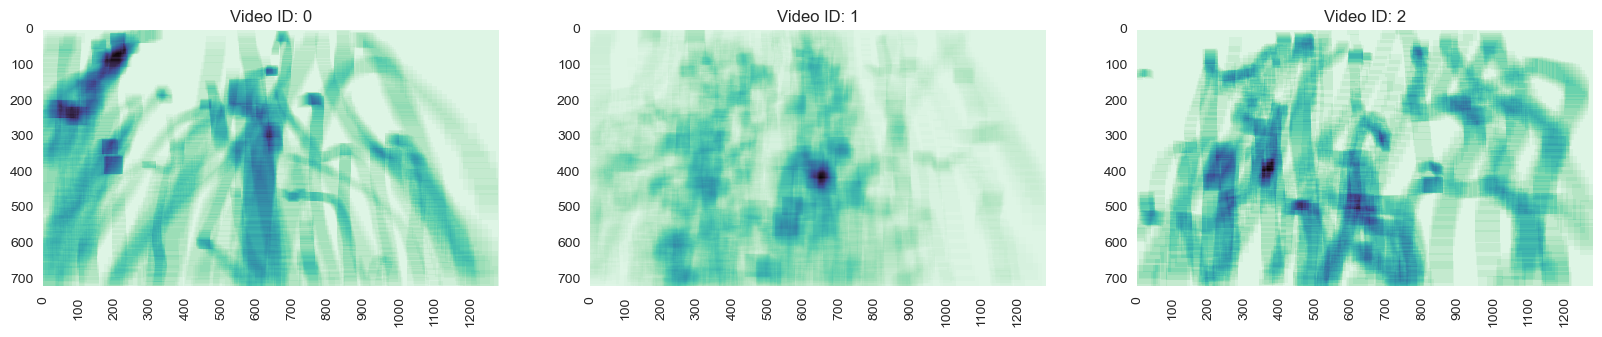

In [515]:
img_width, img_height = 1280, 720

heatmap_dict = {
    '0': np.zeros((img_height, img_width)),
    '1': np.zeros((img_height, img_width)),
    '2': np.zeros((img_height, img_width))
}

fig, ax = plt.subplots(1,3, figsize=(20,5))

for a, i in zip(ax, ['0','1','2']):
    df_bboxs_i = df_bboxs[df_bboxs['Video ID']==i]
    heatmap = heatmap_dict[i]

    for _, row in df_bboxs_i.iterrows():
        x_start, y_start = row['x'], row['y']
        x_end, y_end = x_start + row['width'], y_start + row['height']
    
        x_end = min(x_end, img_width)
        y_end = min(y_end, img_height)
    
        heatmap[y_start:y_end, x_start:x_end] += 1 

    g = sns.heatmap(heatmap, cmap='mako_r', cbar=False, ax=a)
    g.title.set_text('Video ID: {}'.format(i))
    g.set_aspect(1)
    a.set_xticks(range(0,1280,100))
    a.set_xticklabels(range(0,1280,100))
    a.set_yticks(range(0,720,100))
    a.set_yticklabels(range(0,720,100))
    plt.xticks(rotation=90)

plt.show()

Figure 6 displays a scatterplot of bounding box centers, with colors distinguishing between different sequences. The "string-like" structures observed in the heatmaps from Figure 5 can be seen again, especially in Video 0 and 2. Video 1 shows many green and blue points, likely corresponding to the two sequences with over 3,000 images, as noted in Section 2.1. For Videos 0 and 2, the presence of the same sequence across multiple regions in each image suggests that a sequence may represent distinct COTS groupings or that the diver filmed the same group from different angles.

\newpage

<div style="text-align: center;"><strong>Figure 6: Scatterplots of Bounding Box Centers</strong></div>

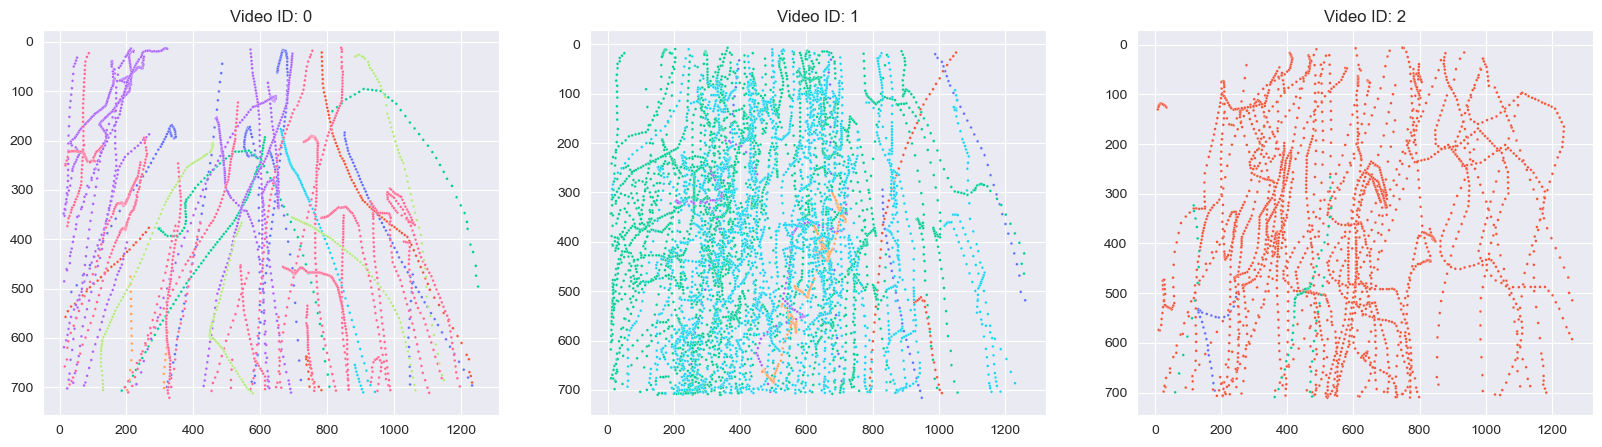

In [516]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

for a, video in zip(ax, ['0', '1', '2']):
    # plt.figure(figsize=(6.4, 3.1))
    sns.set_style('darkgrid')
    g = sns.scatterplot(data=df_bboxs[df_bboxs['Video ID']==video], x='Bounding Box Center, X', y='Bounding Box Center, Y', hue='Sequence', palette=snspal, ax=a, s=4)
    g.title.set_text('Video ID: {}'.format(video))
    a.invert_yaxis()
    a.get_legend().remove()
    a.set(xlabel=None, ylabel=None)
    
plt.show()


# Exploring Image Characteristics
This section examines pixel data to determine any preliminary/distinguishing patterns.

In [517]:
def image_metrics(video_id=0, frame_ids=[], img_height=720, img_width=1280):

    filepath = '/Users/bushra/Documents/STA2453/tensorflow-great-barrier-reef/train_images/video_{}/{}.jpg'
    image_data = []

    pixel_values = {
        'r': np.zeros((img_height, img_width)),
        'g': np.zeros((img_height, img_width)),
        'b': np.zeros((img_height, img_width))
    }

    print('Starting to process images from video {}!'.format(video_id))
    for i in tqdm(frame_ids):
        img = cv2.imread(filepath.format(video_id, i))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR to RBG
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # brightness on greyscale
        brightness = img_gray.mean()

        # Average RGB intensities
        r_mean, g_mean, b_mean = img_rgb[:, :, 0].mean(), img_rgb[:, :, 1].mean(), img_rgb[:, :, 2].mean()

        # Pixel Values
        pixel_values['r'] += img_rgb[:, :, 0]
        pixel_values['g'] += img_rgb[:, :, 1]
        pixel_values['b'] += img_rgb[:, :, 2]

        image_data.append({'image_id': '{}-{}'.format(video_id, i), 'brightness': brightness, 'r': r_mean, 'g': g_mean, 'b': b_mean})
    
    return image_data, pixel_values

In [518]:
# Get frame IDs
video_0_frames = [row['video_frame'] for row in labels.where(F.col('video_id')=='0').select('video_frame').collect()]
video_1_frames = [row['video_frame'] for row in labels.where(F.col('video_id')=='1').select('video_frame').collect()]
video_2_frames = [row['video_frame'] for row in labels.where(F.col('video_id')=='2').select('video_frame').collect()]

# Compute image data
# video_0_image_data, video_0_pixel_values = image_metrics(video_id=0, frame_ids=video_0_frames)
# video_1_image_data, video_1_pixel_values = image_metrics(video_id=1, frame_ids=video_1_frames)
# video_2_image_data, video_2_pixel_values = image_metrics(video_id=2, frame_ids=video_2_frames)

In [519]:
df_pixels = pd.concat(
    [pd.DataFrame(video_0_image_data), pd.DataFrame(video_1_image_data), pd.DataFrame(video_2_image_data)],
    ignore_index=True
    )\
    .merge(
        labels.select('image_id', 'video_id', 'has_cots', 'n_cots_bucket').toPandas(),
        on='image_id'
    )\
    .rename(columns={'brightness': 'Brightness',
                     'video_id': 'Video ID',
                     'has_cots': 'COTS Status',
                     'n_cots_bucket': 'COTS Bucket'})\
    .replace({'COTS Status': 
              {1: 'At Least 1 COTS', 0: 'No COTS'}})

# df_pixels.head()

## Are there any differences in image brightness?
Figure 7 plots the average brightness of each image per video, facetted by the presence of COTS. While the brightness distributions vary significantly across videos, there is no clear indication of substantial differences in brightness based on COTS presence. However, Video 0 shows slightly lower brightness (around 120) compared to Video 1 and 2 (around 130). This could suggest that Video 0 was filmed on a darker day or that the images feature more grey reefs rather than bright blue water.
<div style="text-align: center;"><strong>Figure 7: Distribution of Brightness Levels</strong></div>

<Figure size 500x200 with 0 Axes>

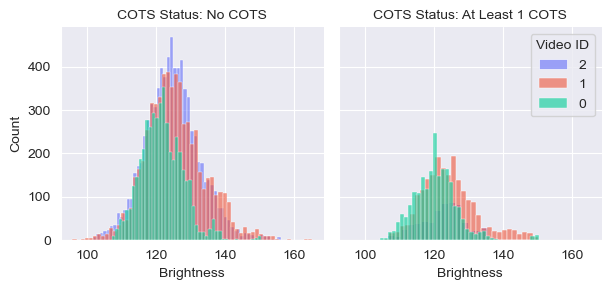

In [520]:
plt.figure(figsize=(5,2))
sns.set_style('darkgrid')

g = sns.FacetGrid(df_pixels, col='COTS Status', col_wrap=3, height=3, sharex=True, sharey=True, hue='Video ID', palette=snspal, hue_order=['2', '1', '0'])
g.map_dataframe(sns.histplot, x='Brightness', alpha=0.6)
g.set_titles(col_template='COTS Status: {col_name}')
plt.legend(title='Video ID')
plt.show()

In [521]:
# plt.figure(figsize=(6.4, 3.1))
# sns.set_style('darkgrid')

# g = sns.FacetGrid(df_pixels, col='COTS Status', col_wrap=3, height=4, sharex=True, sharey=True, hue='COTS Bucket', palette=snspal)
# g.map_dataframe(sns.histplot, x='Brightness')
# g.set_titles(col_template='COTS Status: {col_name}')
# plt.legend(title='COTS Count')
# plt.show()

## Are there any differences in colour intensities?
Figure 8 compares the intensity of the red, green, and blue (RGB) color channels across images with and without COTS. Ignoring the expected difference in scale due to the majority of images having no COTS, the following can be seen:

- For red, the average intensity is around 70 in images without COTS, compared to 50 in images with COTS.
- For green, the average intensity is around 150 for both types of images.
- For blue, the intensity in images without COTS is spread between 125-175, whereas images with COTS average around 175.

When training the model, it may be beneficial to emphasize red pixels since images without COTS show higher red intensity. Computing the variance of blue intensity in images could also be useful since images with COTS exhibit less variance in blue intensity.

<div style="text-align: center;"><strong>Figure 8: Distribution of Colour Intensities</strong></div>

<Figure size 500x200 with 0 Axes>

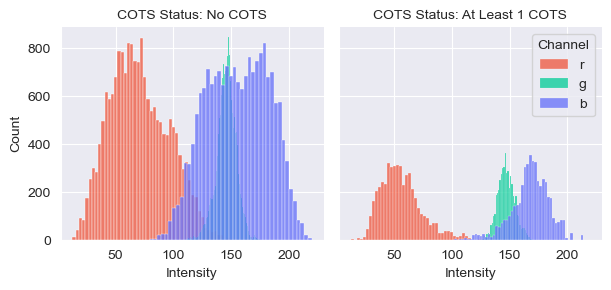

In [522]:
df_rgb = df_pixels\
    .melt(id_vars=['image_id','Video ID', 'COTS Status'], 
          value_vars=['r', 'g', 'b'], 
          var_name='Channel',
          value_name='Intensity')\

plt.figure(figsize=(5,2))
sns.set_style('darkgrid')
g = sns.FacetGrid(df_rgb, col='COTS Status', col_wrap=3, height=3, sharex=True, sharey=True, hue='Channel', palette=[plotly_default[1], plotly_default[2], plotly_default[0]])
g.map_dataframe(sns.histplot, x='Intensity')
g.set_titles(col_template='COTS Status: {col_name}')
plt.legend(title='Channel')
plt.show()

## What is the average pixel value?
Figure 9 shows the "mean image," which averages each pixel across all images per video. This helps reveal the regions where COTS tend to appear, as reefs are usually grey in the dataset (and water is blue). In Video 0, the reef and COTS are concentrated in the middle-to-bottom-left of the frame. On the other hand, Videos 1 and 2 show that COTS tend to appear on the right side of both videos.

\newpage

<div style="text-align: center;"><strong>Figure 9: Images of Average Pixel Values</strong></div>

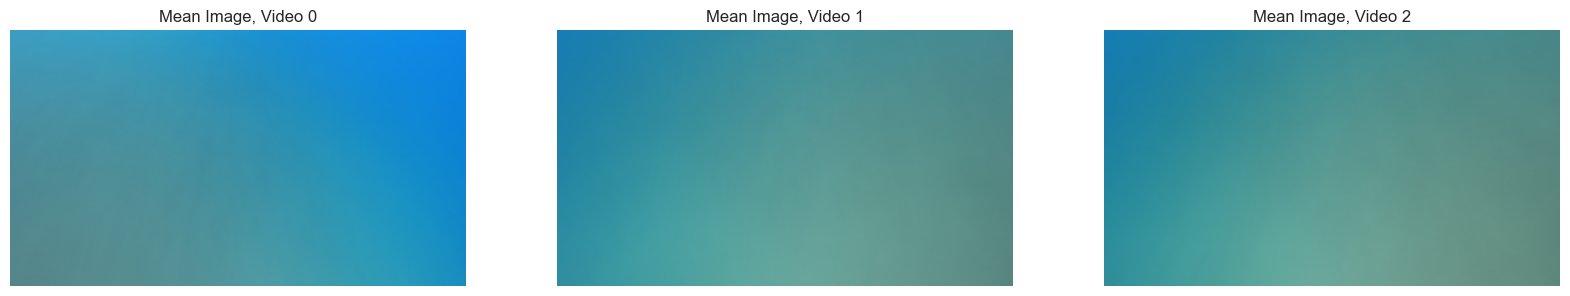

25/02/17 04:26:05 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 219899 ms exceeds timeout 120000 ms
25/02/17 04:26:05 WARN SparkContext: Killing executors is not supported by current scheduler.
25/02/17 04:26:10 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [523]:
video_0_mean_pixels = np.stack([video_0_pixel_values['r'], video_0_pixel_values['g'], video_0_pixel_values['b']], axis=2) / len(video_0_frames)
video_1_mean_pixels = np.stack([video_1_pixel_values['r'], video_1_pixel_values['g'], video_1_pixel_values['b']], axis=2) / len(video_1_frames)
video_2_mean_pixels = np.stack([video_2_pixel_values['r'], video_2_pixel_values['g'], video_2_pixel_values['b']], axis=2) / len(video_2_frames)

fig, ax = plt.subplots(1,3, figsize=(20,4))

ax[0].imshow(np.clip(video_0_mean_pixels, 0, 255).astype(np.uint8)) 
ax[0].set_title('Mean Image, Video 0')
ax[0].axis('off')

ax[1].imshow(np.clip(video_1_mean_pixels, 0, 255).astype(np.uint8)) 
ax[1].set_title('Mean Image, Video 1')
ax[1].axis('off')

ax[2].imshow(np.clip(video_2_mean_pixels, 0, 255).astype(np.uint8)) 
ax[2].set_title('Mean Image, Video 2')
ax[2].axis('off')

plt.show()

# Conclusion
The above analysis of the underwater image data reveals several insights about COTS distribution and image characteristics. Video 0 has a higher proportion of larger bounding boxes but fewer images overall, with COTS clustered mainly in the left-most regions and in distinct "string-like" patterns. Video 1 and 2, while containing more images, show COTS concentrated in the central and right-most regions. The mean image analysis suggests that COTS in Video 0 appear in the middle-to-bottom-left, while in Videos 1 and 2, they are concentrated on the right side. Additionally, the RGB analysis suggests that red intensity is lower in images with COTS, while blue intensity is higher and less variable. These patterns can help to decide first steps for image processing during model development that can in turn improve COTS detection.